# How to create a Quantity of Interest Estimator
This Notebook will take you through:
- What is a Quantity of Interest.
- How it can be estimated.
- How to make it compatible with different sections of the package.
- A more realistic example using:
    - Stochastic Quantity of Interest
    - Simulators with non-gaussian output.

In [262]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.model import Model
from torch.distributions.gumbel import Gumbel

from axtreme.qoi import QoIEstimator

torch.set_default_dtype(torch.float64)

## What is a Quantity of Interest?
Let's assume we have a relationship/function (takes an input, produces an output), and there is something you would like to know about that functions behaviour (we call this the Quantity of Interest - QoI).

For example:
- The function:
    - Input: The wind speed
    - Output: If a wind turbine collapses due to the force of the wind at that speed.
- The quantity of interest (QoI): The maxium wind speed the turbine can withstand without failing

The following shows strategies for obtaining the QoI for a simple and a more realistic function:

### Simple underlying functions
If we know the function (e.g for any wind speed, we know if the turbine collapses) and it is fast and easy to use, then we can easily calculate a QoI on this function. The simplest approach would be to run the function at all possible wind speeds, and take the largest wind speed that doesn't cause failure.

In [228]:
# Some true function that is evaluated
def true_function(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(torch.exp(-x * 10) * 10) * (torch.exp(x))

In [229]:
# The quantity of interest we are interested in
def qoi_of_function(y: torch.Tensor) -> torch.Tensor:
    return y.max(dim=1).values

QoI of the true function:  tensor([[1.2059]])


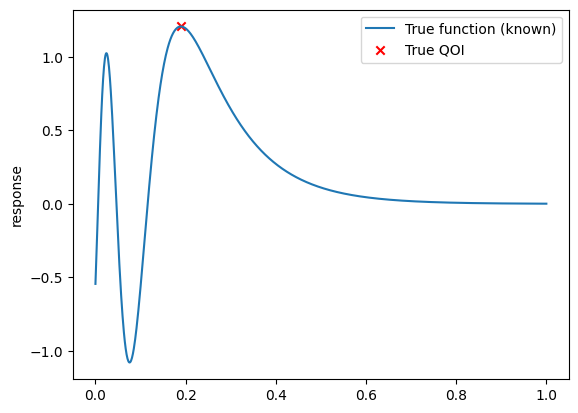

In [231]:
# Plot the true underlying function
x = torch.linspace(0, 1, 1000).view(-1, 1)
y = true_function(x)
_ = plt.plot(x.numpy(), y.numpy(), label="True function (known)")

# Find the true QoI
true_qoi = qoi_of_function(y.unsqueeze(0))
max_index = y.argmax()
x_max = x[max_index]
_ = plt.scatter(x_max, true_qoi.numpy(), c="red", marker="x", label="True QOI")

_ = plt.ylabel("response")
_ = plt.legend()
print("QoI of the true function: ", true_qoi)

### Difficult to evaluate Underlying functions
Unfortunately, the functions we are usually interested in are unknown or difficult to evaluate (slow/expensive). As such the simple approach above is not possible. For example, knowing at what wind speed a turbine collapses would required real world data of turbines collapsing, or complicated/expensive/slow engineering models. In this case how do we then estimate the QoI we need to know?

One approach which is shown below is to:
- Collect some data from the function (e.g run a small number of (expensive) evaluations).
- Based on this data, guess what the function looks like (build a surrogate function). Imagine different possible function, and score how likely it was that it made/generated this data.
- For each possible function, evaluate the QoI.


#### Collect some data

In [232]:
# Assume we have the following data about the true function, but the true function is unknown
train_x = torch.tensor([[0.045], [0.75]])
train_y = true_function(train_x)
train_yvar = torch.tensor([[0.4], [0.05]])

QoI of the true function:  tensor([[1.2059]])


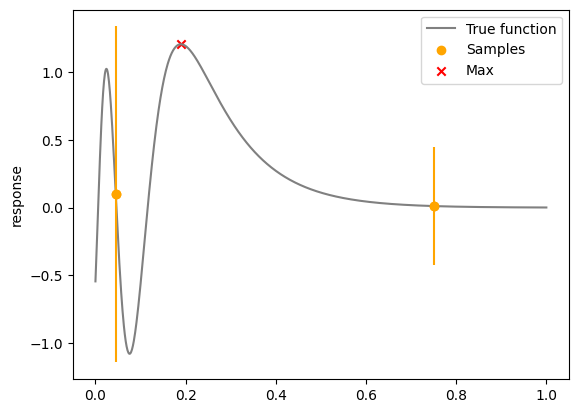

In [233]:
x = torch.linspace(0, 1, 1000).view(-1, 1)
y = true_function(x)
_ = plt.plot(x.numpy(), y.numpy(), color="grey", label="True function (Unknown)")

_ = plt.errorbar(
    train_x.numpy().flatten(),
    train_y.numpy().flatten(),
    yerr=1.96 * train_yvar.numpy().flatten() ** 0.5,
    fmt="o",
    color="orange",
)
_ = plt.scatter(train_x.numpy(), train_y.numpy(), color="orange", label="samples")

true_qoi = qoi_of_function(y.unsqueeze(0))
max_index = y.argmax()
x_max = x[max_index]
_ = plt.scatter(x_max, true_qoi.numpy(), c="red", marker="x", label="True QOI")

_ = plt.ylabel("response")
_ = plt.legend(["True function", "Samples", "Max"])
print("QoI of the true function: ", true_qoi)

#### Estimate the underlying true function from data
To do this we fit a Gaussian Process (GP) to the data we have. We can then use this to produce samples of the possible true underlying function

In [234]:
model = SingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=train_yvar)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)

c:\Users\HENRBE\Documents\axtreme\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0545]), std = tensor([0.0605])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [235]:
# Plotting function to see how the GP fits the data
def plot_gp(
    gp: SingleTaskGP,
    test_x: torch.Tensor,
    training_data: tuple[torch.Tensor, torch.Tensor, torch.Tensor],
    posterior_samples: int = 10,
):
    _, ax = plt.subplots(1, 1, figsize=(6, 4))

    train_x, train_y, yvar = training_data

    # no need for gradients
    with torch.no_grad():
        # compute posterior
        posterior = gp.posterior(test_x)
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.confidence_region()

        # Plot posterior means as blue line
        _ = ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), "b", label="Mean")
        # Shade between the lower and upper confidence bounds
        _ = ax.fill_between(
            test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5, label="Confidence"
        )

        if yvar is None:
            # Plot training points as black stars
            _ = ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), "r*", label="Observed Data")
        else:
            _ = ax.errorbar(
                train_x.cpu().numpy().flatten(),
                train_y.cpu().numpy().flatten(),
                yerr=1.96 * yvar.cpu().numpy().flatten() ** 0.5,
                fmt="o",
                label="Observed Data +- 2*sigma_data",
            )

        # Shape ( number of samples of the func, number of x points func eval at, number of values func predict)
        if posterior_samples > 0:
            samples = posterior.rsample(torch.Size([posterior_samples]))
            for sample in samples:
                _ = ax.plot(test_x.cpu().numpy(), sample.cpu().numpy(), "grey", alpha=0.3)

        _ = ax.legend()
        _ = plt.xlabel("input")
        _ = plt.ylabel("response")
        plt.tight_layout()

        return ax

Show the GPs estimate of the true underlying function. Samples of the GP (grey) are possible functions that generate our training data

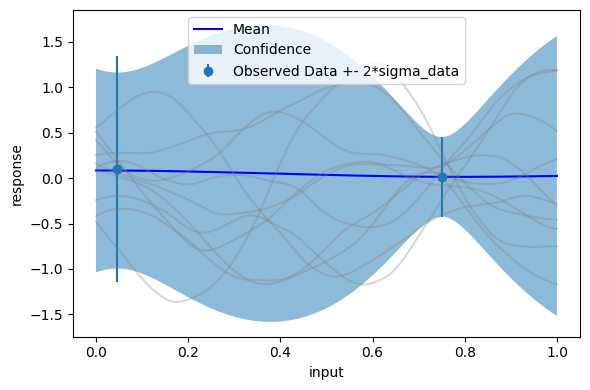

In [236]:
_ = model.eval()
x_test = torch.linspace(0, 1, 100)
num_samples = 10
_ = plot_gp(model, x_test, (train_x, train_y, train_yvar), posterior_samples=num_samples)

#### Quantity of interest estimates for each GP sample
While we don't know what the true underlying function is, the GP can give us 'educated guesses'. We produce multiple candidates from the GP, and then estimate the QOI for each of those. This give us an idea of the possible QoI we could expect.

In [237]:
# Evaluating QoI of samples from the GP
num_estimates = 100
num_evaluation_points = 100

_ = model.eval()
evaluation_points = torch.linspace(0, 1, num_evaluation_points)
posterior = model.posterior(evaluation_points)
samples = posterior.rsample(torch.Size([num_estimates]))
qoi = qoi_of_function(samples)

With these samples from the GP we can plot the different candidate functions and their QoI respectively.

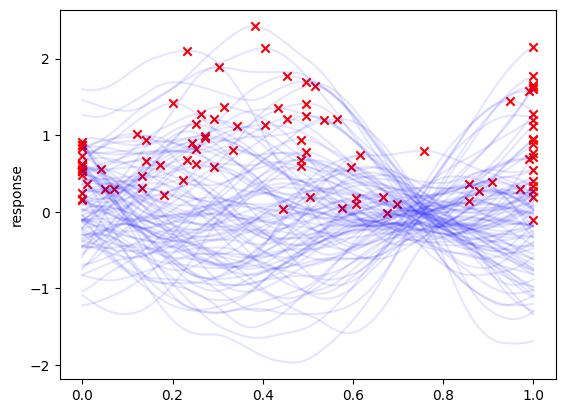

In [238]:
# Each sample is a function candidate from the GP
np_samples = samples.detach().numpy().squeeze().T
_ = plt.plot(evaluation_points.numpy(), np_samples, color="blue", alpha=0.1)
max_indices = np_samples.argmax(axis=0)
max_values = qoi.detach().numpy()
_ = plt.scatter(evaluation_points[max_indices].numpy(), max_values, color="red", marker="x")
_ = plt.ylabel("response")
plt.show()

Let's plot a histogram the different QoIs estimated by the different possible underlying functions (samples of the GP). We can see their distribution, and we might choose the median as our current best guess. 


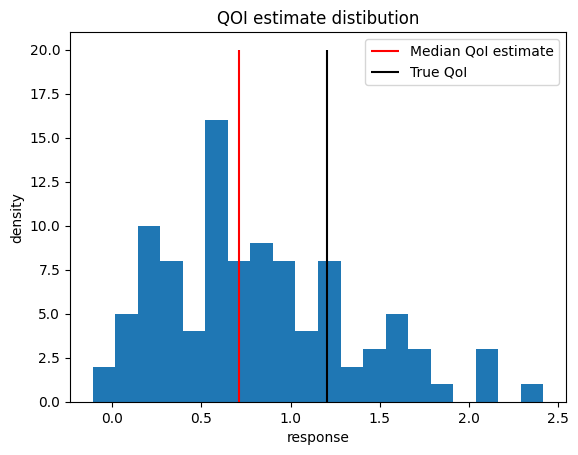

In [239]:
# We can estimate a distribution of the QoI with a histogram of the maximum values
median = qoi.median().detach().numpy()
_ = plt.hist(qoi.detach().numpy(), bins=20)
_ = plt.vlines(median, 0, 20, color="red", label="Median QoI estimate")
_ = plt.vlines(true_qoi, 0, 20, color="black", label="True QoI")
_ = plt.legend()

_ = plt.title("QOI estimate distibution")
_ = plt.xlabel("response")
_ = plt.ylabel("density")
plt.show()

#### Improving our estimate
If we can get more data from our true underlying function we can have can have more certainty in our estimates of this function, which means more certainty in the QoI estimate.
E.g., we reduce the uncertainty in the GP, which will hopefully reduce the variance of the QoI estimates.

In [240]:
_ = model.train()
x_train_new = torch.tensor([[0.2], [0.5]])
y_train_new = true_function(x_train_new)
y_train_new_var = torch.tensor([[0.1], [0.1]])
model = SingleTaskGP(
    train_X=torch.cat([train_x, x_train_new]),
    train_Y=torch.cat([train_y, y_train_new]),
    train_Yvar=torch.cat([train_yvar, y_train_new_var]),
)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)

c:\Users\HENRBE\Documents\axtreme\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3531]), std = tensor([0.5614])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


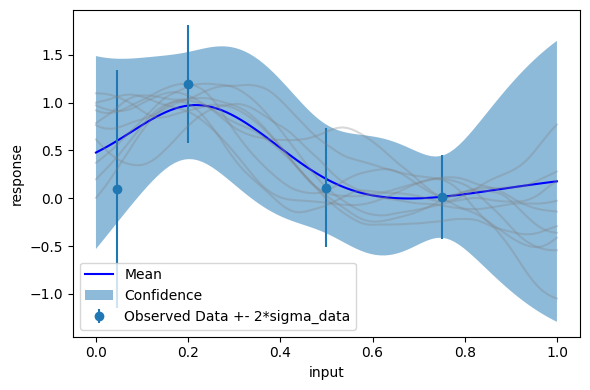

In [241]:
_ = model.eval()

_ = plot_gp(
    model,
    x_test,
    (torch.cat([train_x, x_train_new]), torch.cat([train_y, y_train_new]), torch.cat([train_yvar, y_train_new_var])),
    posterior_samples=num_samples,
)
_ = plt.ylabel("response")

In [242]:
# Evaluatin QoI of samples from the GP
num_estimates = 100
num_evaluation_points = 100

_ = model.eval()
evaluation_points = torch.linspace(0, 1, num_evaluation_points)
posterior = model.posterior(evaluation_points)
samples = posterior.rsample(torch.Size([num_estimates]))
qoi = qoi_of_function(samples)

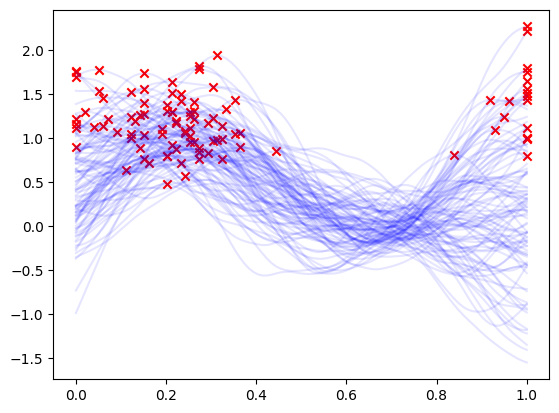

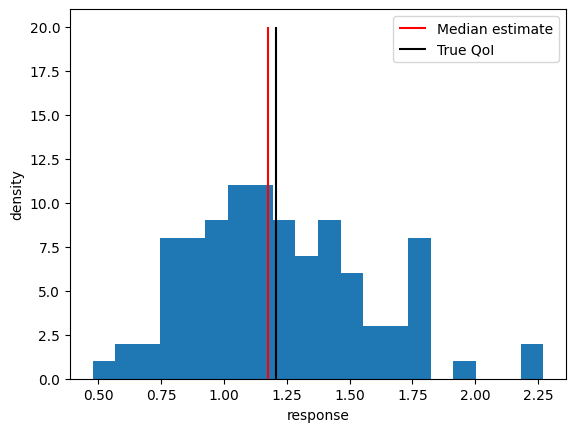

In [243]:
# Each sample is a function candidate from the GP
_ = plt.figure()
np_samples = samples.detach().numpy().squeeze().T
_ = plt.plot(evaluation_points.numpy(), np_samples, color="blue", alpha=0.1)
max_indices = np_samples.argmax(axis=0)
max_values = qoi.detach().numpy()
_ = plt.scatter(evaluation_points[max_indices].numpy(), max_values, color="red", marker="x")

_ = plt.figure()
# We can estimate a distribution of the QoI with a histogram of the maximum values
median = qoi.median().detach().numpy()
_ = plt.hist(qoi.detach().numpy(), bins=20)
_ = plt.vlines(median, 0, 20, color="red", label="Median estimate")
_ = plt.vlines(true_qoi, 0, 20, color="black", label="True QoI")
_ = plt.legend()
_ = plt.ylabel("density")
_ = plt.xlabel("response")
plt.show()

## Implementing a `QoIEstimator`
QoI estimates tend to follow a typical pattern and structure. This is set out in the `QoIEstimtor`. This can help organise QoIs, and has the added benefit of making them compatible with other functionality within this repo.

We have acquisition functions that make use of QoI if this complies with the `QoIEstimator` `Protocol`. A Quantity of Interest estimator in the context of these acquisition functions is just something that can be called with only a `botorch` `Model` as an input and returns a 1D `torch.Tensor` where each element is an estimate of the scalar Quantity of Interest. 




In [244]:
# This is the same as the qoi_of_function used above
def qoi(y: torch.Tensor) -> torch.Tensor:
    return y.max(dim=1).values


def estimate_qoi(model: Model, num_estimates: int, num_evaluation_points: int):
    _ = model.eval()
    evaluation_points = torch.linspace(0, 1, num_evaluation_points)
    posterior = model.posterior(evaluation_points)
    samples = posterior.rsample(torch.Size([num_estimates]))
    qoi_estimates = qoi(samples).squeeze()  # makes the output shape 1d
    return qoi_estimates

In [245]:
# With the new function we can estimate the QoI
model = SingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=train_yvar)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)
_ = estimate_qoi(model, 10, 100).squeeze().detach().numpy()

c:\Users\HENRBE\Documents\axtreme\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0545]), std = tensor([0.0605])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


### Complying with input signature

Complying with the input signature means that the function can only have a single input of a `botorch` `Model`. This can naively be done by putting the arguments inside the function.

In [246]:
# This complies with the QoIEstimator Protocol
# However, it is a bad solution because function must be modified to change the parameters/arguments.
def estimate_qoi(model: Model):
    num_estimates = 100
    num_evaluation_points = 100

    _ = model.eval()
    evaluation_points = torch.linspace(0, 1, num_evaluation_points)
    posterior = model.posterior(evaluation_points)
    samples = posterior.rsample(torch.Size([num_estimates]))
    qoi_estimates = qoi(samples).squeeze()
    return qoi_estimates

The `QoIEstimator` `Protocol` limits the function to only have a `Model` as an input. This is quite limiting for what the Quantity of Interest estimator can do. However, this can be handled by a closure or a class that will take care of any other arguments that the QoI estimator function might need. A class might be the better choice since it can allow for more complex behaviour and abstraction. However, a closure might be easier to implement. When using a class on can inherit from `QoIEstimator`.

Below the same simple QoI estimator is implemented as a class, with the possibility to change the points one samples the posterior at and how many different estimates should be calculated.

In [247]:
# Handle args in the QoI estimator with a class
# Inheriting from QoIEstimator
class EstimateQoIArguments(QoIEstimator):
    def __init__(self, num_estimates: int, num_evaluation_points: int) -> None:
        self.num_estimates = num_estimates
        self.num_evaluation_points = num_evaluation_points

    def qoi(self, samples: torch.Tensor) -> torch.Tensor:
        return samples.max(dim=1).values

    def __call__(self, model: Model) -> torch.Tensor:
        evaluation_points = torch.linspace(0, 1, self.num_evaluation_points)
        posterior = model.posterior(evaluation_points)
        samples = posterior.rsample(torch.Size([self.num_estimates]))
        qoi_estimates = self.qoi(samples).squeeze()
        return qoi_estimates

In [248]:
qoi_estimator = EstimateQoIArguments(num_estimates=10, num_evaluation_points=100)
qoi_estimates = qoi_estimator(model)
print(qoi_estimates)

tensor([0.5817, 0.7027, 0.3176, 1.0063, 0.8435, 0.9030, 1.3659, 1.0305, 0.2334,
        0.7057], grad_fn=<SqueezeBackward0>)


Below the same simple QoI estimator is implemented as a closure

In [249]:
# Handling args in the QoI estimator with a closure
def estimate_qoi_closure(num_estimates: int, num_evaluation_points: int) -> QoIEstimator:
    def qoi(samples: torch.Tensor) -> torch.Tensor:
        return samples.max(dim=1).values

    def estimate_qoi(model: Model) -> torch.Tensor:
        _ = model.eval()
        evaluation_points = torch.linspace(0, 1, num_evaluation_points)
        posterior = model.posterior(evaluation_points)
        samples = posterior.rsample(torch.Size([num_estimates]))
        qoi_estimates = qoi(samples).squeeze()
        return qoi_estimates

    return estimate_qoi

In [250]:
qoi_estimator = estimate_qoi_closure(num_estimates=10, num_evaluation_points=100)
qoi_estimates = qoi_estimator(model)
print(qoi_estimates)

tensor([ 1.1827,  1.6052,  1.4667,  0.3404,  0.8249,  0.7600,  0.4326, -0.1078,
         0.6210,  0.8220], grad_fn=<SqueezeBackward0>)


## Adding complexity to QoI closer to a real application
There are two additional complixities we often need to deal with that will be introduced here:
1. The QoI function can itself have noise/randomness within it (e.g if it involves sampling from a distirbution).
2. The true function gives predictions that have a non-Gaussian distribution (e.g non-gaussian noise)

### 1. Stochastic QoI functions :
Due to the randomness, running the QoI function once on a single input function is no longer enough. We need to run it multiple time (sample it) to get a better idea of the QoI value for this function. In other words, we get a distribution of results from QoI evalutaion on a single input function.

### 2. Non-gaussian output distribution.
Our true underlying function might also give noisy/stochastic output. If this noise is not Gaussian, we need to update how we build our surrogate model of the true function (our GP). Instead of modeling the true function output directly with our GP, we decide on the output noise distribution, and then use the GP to model the parameters of that distribution.

Making a prediction then looks as follows:
- give data point to GP
- GP output parameters of the distibution (e.g location and scale)
- Create a distibution from those parameters (e.g Gumbel(location, scale))
- Pick a point from this distibution to use (e.g the median or a random sample)


We have now introduced 2 different types of noise that we typically have to deal with. The following shows a simple example of doing this.

### Using the true underling function directly and estimating the QoI
Include the effect of a stochastic QoI function, and non-gaussian output

In [251]:
# Create a new true function, which is powered by 2 underlying functions for location and scale.
def true_location(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(torch.exp(-x * 10) * 10) * (torch.exp(x))


def true_scale(x: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(torch.square(x) + torch.square(x) + 0.1)


def true_function(x: torch.Tensor) -> torch.Tensor:
    loc = true_location(x)
    scale = true_scale(x)
    return Gumbel(loc, scale).sample(torch.Size([1]))


# Typically we would call the `true_funciton` multiple times
# at a single x to then get an estimate of the location and scale
# for simplicity we cheat and use the actual values
def estimate_location(x: torch.Tensor) -> torch.Tensor:
    # some functionality which gets us an estimate
    return true_location(x)


def estimate_scale(x: torch.Tensor) -> torch.Tensor:
    # some functionality which gets us an estimate
    return true_scale(x)

Text(0.5, 1.0, 'True function distribution and samples')

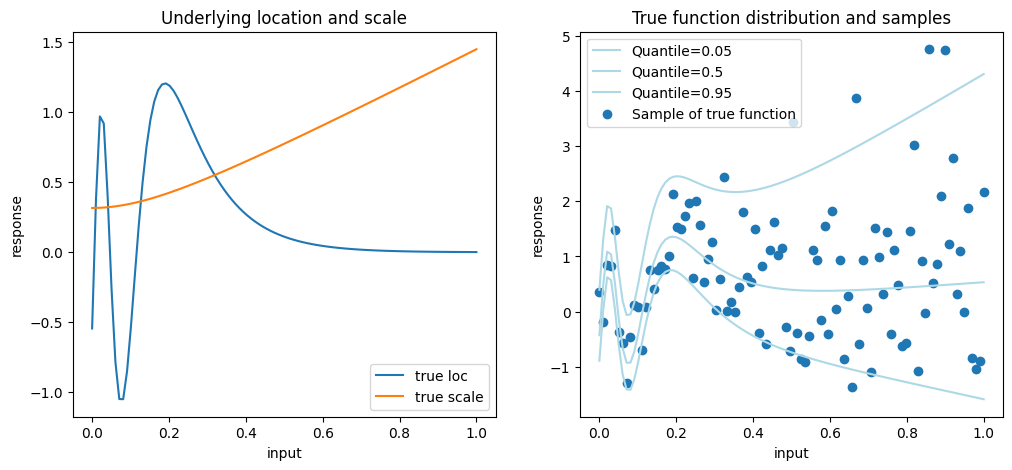

In [252]:
# Plotting the true function with the location and scale
_, axes = plt.subplots(1, 2, figsize=(12, 5))

x = torch.linspace(0, 1, 100).reshape(-1, 1)
axes[0].plot(x.numpy(), true_location(x).numpy(), label="true loc")
axes[0].plot(x.numpy(), true_scale(x).numpy(), label="true scale")
axes[0].legend()
axes[0].set_xlabel("input")
axes[0].set_ylabel("response")
axes[0].set_title("Underlying location and scale")


for q in [0.05, 0.5, 0.95]:
    axes[1].plot(
        x.numpy(), Gumbel(true_location(x), true_scale(x)).icdf(q).numpy(), label=f"Quantile={q}", c="lightblue"
    )

axes[1].scatter(x.numpy(), true_function(x).numpy(), label="Sample of true function")
axes[1].legend()
axes[1].set_xlabel("input")
axes[1].set_ylabel("response")
axes[1].set_title("True function distribution and samples")

### Calculating true QoI by sampling using true function
We are interested in the maximum value typically produced by the true function when it is run on a fixed set of inputs x. The true function gives stochastic output, the QoI is now also stochastic, so we get a distibution.

For simplicity, in this example we say we are interested in a fixed set of `x` values.

We can frame it as running the True function and calculating the QoI from the outputs

mean qoi estimate 5.197143915598894


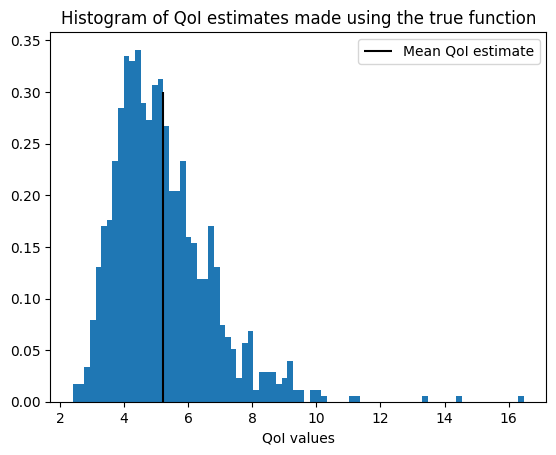

In [253]:
_ = torch.manual_seed(7)  # seeding for reproducibility


def qoi(x: torch.Tensor) -> torch.Tensor:
    """
    Args:
        x (torch.Tensor): The response of the true function to calculate the QoI on. (e.g outputs of the True function)

    Returns
    -------
        the QOI for this input
    """
    return x.max()


number_of_qoi_estimates = 1000
estimates = []
for _ in range(number_of_qoi_estimates):
    sample = true_function(x)
    estimates.append(qoi(sample).item())

_ = plt.hist(estimates, bins=80, density=True)
_ = plt.xlabel("QoI values")
mean_est = sum(estimates) / len(estimates)
print(f"mean qoi estimate {mean_est}")
_ = plt.vlines(mean_est, 0, 0.3, color="black", label="Mean QoI estimate")
_ = plt.legend()
_ = plt.title("Histogram of QoI estimates made using the true function");

We can also frame it as running the underlying true location and scale functions, and calculating the QoI based on that information. This shifts the randomness into the QoI function. This is the approach we will take as it is more compatible with GP modelling, and is what we will use in later steps.

In [254]:
def qoi_stochastic(x: torch.Tensor, number_of_qoi_estimates: int = 1000) -> torch.Tensor:
    """
    Args:
        x (torch.Tensor): (n,2) The location and scale parameters the QOI should be calcuated over
        number_of_qoi_estimates (int, optional): How many estimates of the QOI should be calculated

    Returns
    -------
        torch.Tensor: number_of_qoi_estimates of the QOI for this set of location and scale inputs
    """
    return Gumbel(loc=x[:, 0], scale=x[:, 1]).sample(torch.Size([number_of_qoi_estimates])).max(axis=1).values

mean qoi estimate 5.197143915598895


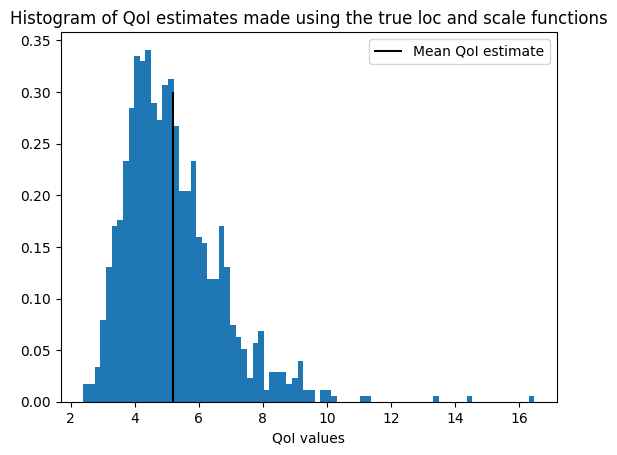

In [255]:
_ = torch.manual_seed(7)
true_locs = true_location(x)
true_scales = true_scale(x)
estimates = qoi_stochastic(torch.hstack([true_locs, true_scales])).numpy()

_ = plt.hist(estimates, bins=80, density=True)
_ = plt.xlabel("QoI values")
mean_est = sum(estimates) / len(estimates)
print(f"mean qoi estimate {mean_est}")
_ = plt.vlines(mean_est, 0, 0.3, color="black", label="Mean QoI estimate")
_ = plt.legend()
_ = plt.title("Histogram of QoI estimates made using the true loc and scale functions");

### Calcuate the QoI estimate using samples from the true function
Here we again assume that we cannot run the true function often, so we instead collect data from it, and use a GP to track our "educated guesses" of what the true underlying function could be. 

Define the mock data we have received from our true underling function

In [256]:
train_x = torch.tensor([[0.045], [0.75]])
train_yvar = torch.tensor([[0.4, 0.4], [0.05, 0.05]])
# here we use our estimate of the location and scale. We assume that we get that by running the true function multiple
# times, and then estimating the results.
train_y = torch.hstack([estimate_location(train_x), estimate_scale(train_x)])

Fit a model to represent our "best guess" of the underling functions given the data

In [257]:
model = SingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=train_yvar)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)

c:\Users\HENRBE\Documents\axtreme\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0545, 0.7147]), std = tensor([0.0605, 0.5545])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Text(0.5, 1.0, 'GP and True function distribution and samples')

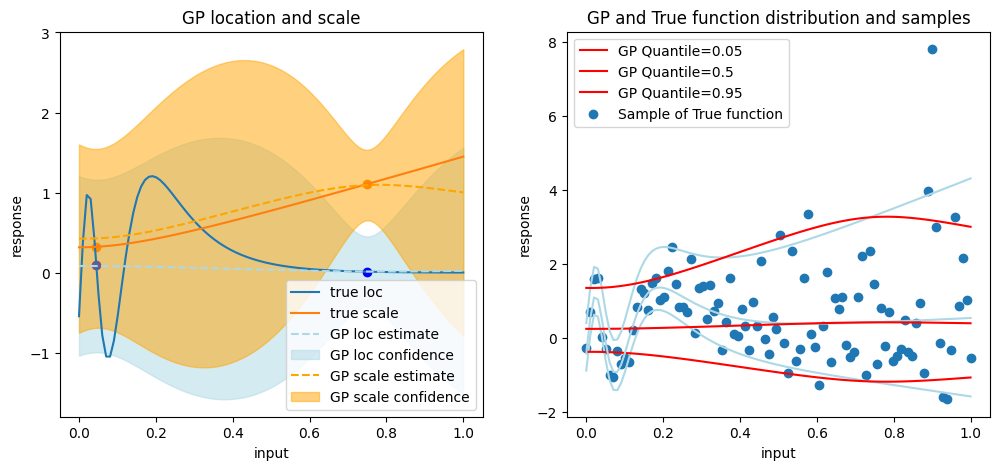

In [258]:
# Plotting the GP with the location and scale
_, axes = plt.subplots(1, 2, figsize=(12, 5))

x = torch.linspace(0, 1, 100).reshape(-1, 1)
axes[0].plot(x.numpy(), true_location(x).numpy(), label="true loc")
axes[0].plot(x.numpy(), true_scale(x).numpy(), label="true scale")
axes[0].set_xlabel("input")
axes[0].set_ylabel("response")
axes[0].set_title("GP location and scale")

with torch.no_grad():
    posterior = model.posterior(x)
    means = posterior.mean
    variances = posterior.variance

axes[0].plot(x.flatten(), means[:, 0], "--", label="GP loc estimate", color="lightblue")
axes[0].fill_between(
    x.flatten(),
    means[:, 0] - 2 * variances[:, 0] ** 0.5,
    means[:, 0] + 2 * variances[:, 0] ** 0.5,
    alpha=0.5,
    label="GP loc confidence",
    color="lightblue",
)
axes[0].scatter(train_x, train_y[:, 0], color="blue")

axes[0].plot(x.flatten(), means[:, 1], "--", label="GP scale estimate", color="orange")
axes[0].fill_between(
    x.flatten(),
    means[:, 1] - 2 * variances[:, 1] ** 0.5,
    means[:, 1] + 2 * variances[:, 1] ** 0.5,
    alpha=0.5,
    label="GP scale confidence",
    color="orange",
)
axes[0].scatter(train_x, train_y[:, 1], color="darkorange")
axes[0].legend()

for q in [0.05, 0.5, 0.95]:
    axes[1].plot(x.numpy(), Gumbel(true_location(x), true_scale(x)).icdf(q).numpy(), c="lightblue")
    axes[1].plot(x.numpy(), Gumbel(means[:, 0], means[:, 1]).icdf(q).numpy(), label=f"GP Quantile={q}", c="red")

axes[1].scatter(x.numpy(), true_function(x).numpy(), label="Sample of True function")
axes[1].legend()
axes[1].set_xlabel("input")
axes[1].set_ylabel("response")
axes[1].set_title("GP and True function distribution and samples")

There are now 2 sources of uncertainty in out QoIEstimator:
- We are uncertain about the true underlying function, so in `__call__` we draw samples of what we think might be the true underlying function.
- The QoI calculation is stochastic, meaning that for a single input, it produces a distibution of possible outputs.
    - in `qoi()` we sample this distibution of possible outputs, and then take the median of those which is our "best guess" of the QOI for that input function.

In [259]:
class EstimateQoI(QoIEstimator):
    def __init__(self, num_function_samples: int, num_qoi_samples_per_func: int) -> None:
        self.num_function_samples = num_function_samples
        self.num_qoi_samples_per_func = num_qoi_samples_per_func

    def qoi(self, samples: torch.Tensor) -> torch.Tensor:
        loc = samples[:, :, 0]
        # Since the scale must be positive, we clamp it to a small value
        scale = samples[:, :, 1].clamp(min=1e-6)
        gumbel = torch.distributions.gumbel.Gumbel(loc, scale)

        # Taking multiple samples from the Gumbel distribution
        gumbel_samples = gumbel.sample(torch.Size([self.num_qoi_samples_per_func]))

        # Taking the maximum value over the evaluation points for each sample to find the QoI
        gumbel_max = gumbel_samples.max(dim=-1).values

        # Taking the median of the maximum values
        gumbel_max_median = gumbel_max.median(dim=0).values
        return gumbel_max_median

    def __call__(self, model: Model) -> torch.Tensor:
        # In this example the points we need to evaluate at is always fixed
        evaluation_points = torch.linspace(0, 1, 100).reshape(-1, 1)
        posterior = model.posterior(evaluation_points)
        samples = posterior.rsample(torch.Size([self.num_function_samples]))
        qoi_estimates = self.qoi(samples).squeeze()

        return qoi_estimates

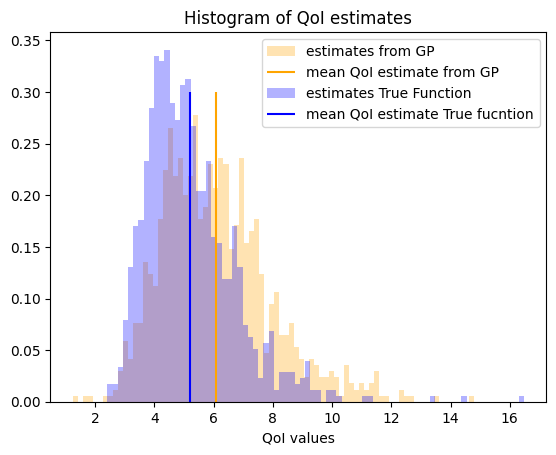

In [261]:
qoi_estimator = EstimateQoI(num_function_samples=1000, num_qoi_samples_per_func=100)
qoi_estimates = qoi_estimator(model)

_ = plt.hist(qoi_estimates, bins=80, density=True, alpha=0.3, label="estimates from GP", color="orange")
_ = plt.vlines(qoi_estimates.mean(), 0, 0.3, label="mean QoI estimate from GP", color="orange")
_ = plt.xlabel("QoI values")

_ = plt.hist(estimates, bins=80, density=True, alpha=0.3, label="estimates True Function", color="blue")
_ = plt.vlines(estimates.mean(), 0, 0.3, label="mean QoI estimate True fucntion", color="blue")
_ = plt.xlabel("QoI values")

_ = plt.legend()
_ = plt.title("Histogram of QoI estimates")